# LeR Advanced Sampling - Generating Detectable Events

This notebook is created by [Phurailatpam Hemantakumar](https://hemantaph.com)

[![Documentation](https://img.shields.io/badge/ler-documentation-blue)](https://ler.hemantaph.com) 

This notebook demonstrates how to generate a specific number of detectable events and monitor detection rate convergence as a function of sample size using the **`LeR`** package.

**Key Features Demonstrated:**
- Continue sampling in batches until at least N detectable events are found
- Monitor rate convergence using stopping criteria
- Resume capability for interrupted sampling sessions
- Visualization of rate convergence and parameter distributions

---

## Table of Contents

1. [Initialize LeR](#1-initialize-ler)
2. [Sampling N Detectable Events](#2-sampling-n-detectable-events)
   - [2.1 Sampling Unlensed Events](#21-sampling-unlensed-events)
   - [2.2 Analyze Rate Convergence (Unlensed)](#22-analyze-rate-convergence-unlensed)
   - [2.3 Assess Rate Stability (Unlensed)](#23-assess-rate-stability-unlensed)
   - [2.4 Sampling Lensed Events](#24-sampling-lensed-events)
   - [2.5 Analyze Rate Convergence (Lensed)](#25-analyze-rate-convergence-lensed)
   - [2.6 Assess Rate Stability (Lensed)](#26-assess-rate-stability-lensed)
   - [2.7 Rate Comparison](#27-rate-comparison)
3. [Compare All Sampled and Detectable Event Parameters](#3-compare-all-sampled-and-detectable-event-parameters)
   - [3.1 Unlensed Parameter Distributions](#31-unlensed-parameter-distributions)
   - [3.2 Lensed Parameter Distributions](#32-lensed-parameter-distributions)
4. [Visualizing Lensed Detectable Events](#4-visualizing-lensed-detectable-events)
   - [4.1 Redshift Distribution](#41-redshift-distribution)
   - [4.2 Magnification Ratio vs Time Delay](#42-magnification-ratio-vs-time-delay)
   - [4.3 Caustic Plot with Source and Image Positions](#43-caustic-plot-with-source-and-image-positions)
5. [Summary](#5-summary)

---

## 1. Initialize LeR

The `LeR` class is the main interface for simulating gravitational lensing effects on GW events and calculating lensed rates. We use default settings to initialize the LeR package:

- **Event type:** BBH (Binary Black Hole)
- **Lens galaxy model:** EPL+Shear (Elliptical Power Law galaxy with external shears)
- **Detectors:** H1, L1, V1 (LIGO Hanford, LIGO Livingston, Virgo) with O4 design sensitivity

All outputs will be saved in the `./ler_data` directory by default.

In [2]:
# Import LeR
from ler.rates import LeR

# Initialize LeR with default settings
# npool: number of parallel processes for sampling
ler = LeR(npool=6)


Initializing LeR class...



```python
# To print all initialization input arguments, use:
ler._print_all_init_args()
```

---

## 2. Sampling N Detectable Events

This section demonstrates how to sample GW events until a specified number of detectable events is collected. The key features include:

- **Batch processing:** Events are sampled in batches for efficiency
- **Convergence monitoring:** Rate stability is monitored using stopping criteria
- **Resume capability:** Sampling can be resumed if interrupted

### 2.1 Sampling Unlensed Events

Generate unlensed detectable events with the following parameters:
- `size`: Target number of detectable events to collect
- `batch_size`: Number of events to sample per batch
- `stopping_criteria`: Convergence conditions (relative rate difference and number of batches to check)
- `pdet_threshold`: Probability of detection threshold for considering an event as detectable
- `resume`: Whether to resume from a previous sampling session

In [3]:
# Sample until we have at least 10,000 detectable unlensed events with converged rates
# use 'print(ler.selecting_n_unlensed_detectable_events.__doc__)' to see all input args
detectable_rate_unlensed, unlensed_param_detectable_n = ler.selecting_n_unlensed_detectable_events(
    size=10000,                          # Target number of detectable events
    batch_size=100000,                   # Events per batch
    stopping_criteria=dict(
        relative_diff_percentage=0.1,    # Stop when rate change < 0.1%
        number_of_last_batches_to_check=4  # Check last 4 batches for convergence
    ),
    pdet_threshold=0.5,                  # Probability threshold for detection
    resume=True,                         # Resume from previous state if available
    output_jsonfile='unlensed_params_n_detectable.json',  # Output file for detectable events
    meta_data_file='meta_unlensed.json', # Store metadata (rates per batch)
    pdet_type='boolean',                 # Detection type: 'boolean' or 'float'
    trim_to_size=False,                  # Keep all events found until convergence
)

print(f"\n=== Unlensed N-Event Sampling Results ===")
print(f"Detectable event rate: {detectable_rate_unlensed:.4e} events per year")
print(f"Total detectable events collected: {len(unlensed_param_detectable_n['zs'])}")

stopping criteria set to when relative difference of total rate for the last 4 cumulative batches is less than 0.1%.
sample collection will stop when the stopping criteria is met and number of detectable events exceeds the specified size.
Resuming from 11062.0 detectable events.
percentage difference of total rate for the last 4 cumulative batches = [0.01807991 0.00109575 0.00877408 0.        ]
stopping criteria of rate relative difference of 0.1% for the last 4 cumulative batches reached.
Given size=10000 reached

Stopping criteria met. There will be no more samples collected.
collected number of detectable events =  11062.0
stored detectable unlensed params in ./ler_data/unlensed_params_n_detectable.json
stored meta data in ./ler_data/meta_unlensed.json

=== Unlensed N-Event Sampling Results ===
Detectable event rate: 2.8946e+02 events per year
Total detectable events collected: 11062


### 2.2 Analyze Rate Convergence (Unlensed)

Visualize how the detection rate evolves as more events are sampled. A converged rate indicates stable statistics.

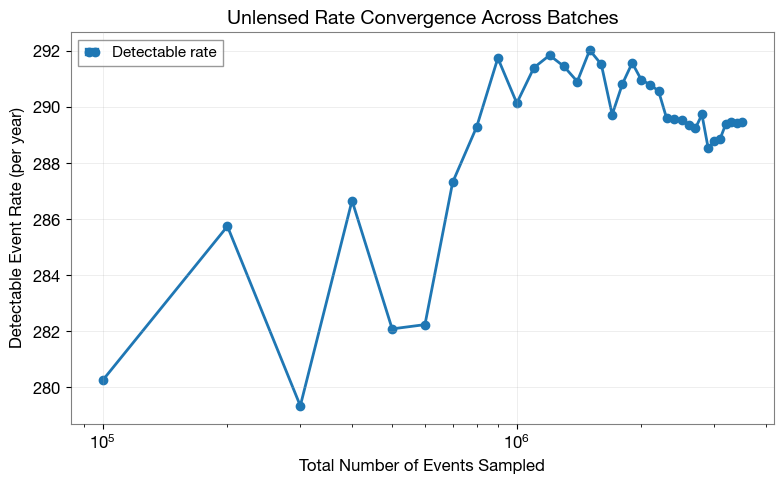

In [4]:
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

# Load metadata containing rates for each batch
meta_data = get_param_from_json(ler.ler_directory + '/meta_unlensed.json')

# Plot rate vs sampling size
plt.figure(figsize=(8, 5))
plt.plot(
    meta_data['events_total'],
    meta_data['total_rate'],
    'o-',
    linewidth=2,
    markersize=6,
    color='C0',
    label='Detectable rate'
)

plt.xlabel('Total Number of Events Sampled', fontsize=12)
plt.ylabel('Detectable Event Rate (per year)', fontsize=12)
plt.title('Unlensed Rate Convergence Across Batches', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.xscale('log')
plt.tight_layout()
plt.show()

### 2.3 Assess Rate Stability (Unlensed)

Calculate the mean and standard deviation of rates from the last few batches to quantify convergence.

In [5]:
import numpy as np

# Select rates from the last 4 batches
idx_converged = [-4, -3, -2, -1]
rates_converged = np.array(meta_data['total_rate'])[idx_converged]

if len(rates_converged) > 0:
    mean_rate = rates_converged.mean()
    std_rate = rates_converged.std()
    
    print(f"=== Unlensed Rate Stability Analysis ===")
    print(f"Number of batches analyzed: {len(rates_converged)}")
    print(f"Mean rate: {mean_rate:.4e} events/year")
    print(f"Standard deviation: {std_rate:.4e} events/year")
    print(f"Relative uncertainty: {(std_rate/mean_rate)*100:.3f}%")
else:
    print("Not enough batches to assess convergence.")

# Update the rate with the converged mean
detectable_rate_unlensed = mean_rate

=== Unlensed Rate Stability Analysis ===
Number of batches analyzed: 4
Mean rate: 2.8944e+02 events/year
Standard deviation: 2.2384e-02 events/year
Relative uncertainty: 0.008%


### 2.4 Sampling Lensed Events

Generate lensed detectable events. For lensed events, we can specify:
- `pdet_threshold`: List of detection thresholds for each image
- `num_img`: Number of images that must meet each corresponding threshold

For this example, I set `stopping_criteria=None` and the sampling will continue until at least 1000 detectable lensed events are collected.

In [6]:
# Sample until we have at least 1,000 detectable lensed events
# use 'print(ler.selecting_n_lensed_detectable_events.__doc__)' to see all input args
detectable_rate_lensed, lensed_param_detectable_n = ler.selecting_n_lensed_detectable_events(
    size=1000,                           # Target number of detectable events
    batch_size=50000,                    # Events per batch
    stopping_criteria=None,              # No stopping criteria (sample until size is reached)
    pdet_threshold=[0.5, 0.5],           # Detection thresholds for images
    num_img=[1, 1],                      # Number of images required per threshold
    resume=True,                        # Resume from previous state if available
    output_jsonfile='lensed_params_n_detectable.json',
    meta_data_file='meta_lensed.json',
    pdet_type='boolean',
    trim_to_size=False,
)

print(f"\n=== Lensed N-Event Sampling Results ===")
print(f"Detectable event rate: {detectable_rate_lensed:.4e} events per year")
print(f"Total detectable events collected: {len(lensed_param_detectable_n['zs'])}")

stopping criteria not set. sample collection will stop when number of detectable events exceeds the specified size.
Resuming from 1014.0 detectable events.
Given size=1000 reached

Stopping criteria met. There will be no more samples collected.
collected number of detectable events =  1014.0
storing detectable lensed params in ./ler_data/lensed_params_n_detectable.json
storing meta data in ./ler_data/meta_lensed.json

=== Lensed N-Event Sampling Results ===
Detectable event rate: 9.5750e-02 events per year
Total detectable events collected: 1014


### 2.5 Analyze Rate Convergence (Lensed)

Visualize the lensed detection rate evolution across batches.

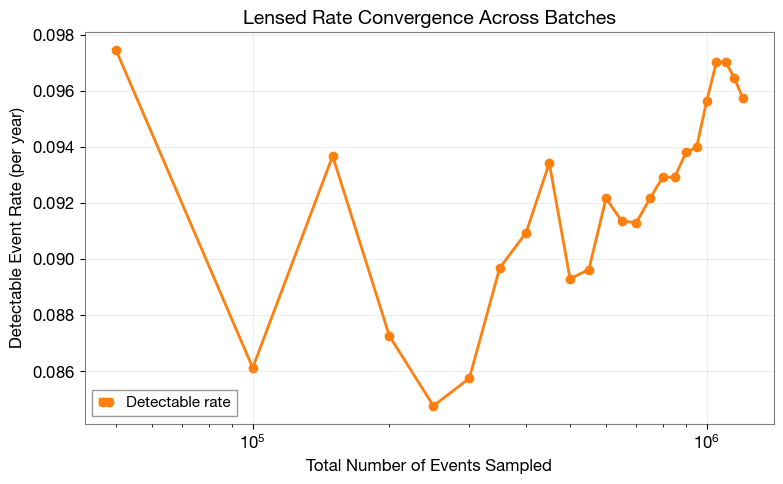

In [7]:
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

# Load metadata containing rates for each batch
meta_data = get_param_from_json(ler.ler_directory + '/meta_lensed.json')

# Plot rate vs sampling size
plt.figure(figsize=(8, 5))
plt.plot(
    meta_data['events_total'],
    meta_data['total_rate'],
    'o-',
    linewidth=2,
    markersize=6,
    color='C1',
    label='Detectable rate'
)

plt.xlabel('Total Number of Events Sampled', fontsize=12)
plt.ylabel('Detectable Event Rate (per year)', fontsize=12)
plt.title('Lensed Rate Convergence Across Batches', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.xscale('log')
plt.tight_layout()
plt.show()

### 2.6 Assess Rate Stability (Lensed)

Calculate the mean and standard deviation of lensed rates from the last few batches.

In [8]:
import numpy as np

# Select rates from the last 4 batches
idx_converged = [-4, -3, -2, -1]
rates_converged = np.array(meta_data['total_rate'])[idx_converged]

if len(rates_converged) > 0:
    mean_rate = rates_converged.mean()
    std_rate = rates_converged.std()
    
    print(f"=== Lensed Rate Stability Analysis ===")
    print(f"Number of batches analyzed: {len(rates_converged)}")
    print(f"Mean rate: {mean_rate:.4e} events/year")
    print(f"Standard deviation: {std_rate:.4e} events/year")
    print(f"Relative uncertainty: {(std_rate/mean_rate)*100:.3f}%")
else:
    print("Not enough batches to assess convergence.")

# Update the rate with the converged mean
detectable_rate_lensed = mean_rate

=== Lensed Rate Stability Analysis ===
Number of batches analyzed: 4
Mean rate: 9.6567e-02 events/year
Standard deviation: 5.2511e-04 events/year
Relative uncertainty: 0.544%


### 2.7 Rate Comparison

Compare the detection rates between lensed and unlensed events.

In [9]:
# Compare lensed vs unlensed rates
print(f"=== Detection Rate Comparison ===")
print(f"Unlensed detectable rate: {detectable_rate_unlensed:.4e} events/year")
print(f"Lensed detectable rate:   {detectable_rate_lensed:.4e} events/year")
print(f"Ratio (Unlensed/Lensed):  {(detectable_rate_unlensed/detectable_rate_lensed):.2f}")

=== Detection Rate Comparison ===
Unlensed detectable rate: 2.8944e+02 events/year
Lensed detectable rate:   9.6567e-02 events/year
Ratio (Unlensed/Lensed):  2997.28


---

## 3. Compare All Sampled and Detectable Event Parameters

This section visualizes the difference in parameter distributions between all sampled events and detectable events only. Corner plots reveal how detector sensitivity introduces **selection effects** that bias the observed population toward certain parameter values.

### 3.1 Unlensed Parameter Distributions

First, generate a large sample of all unlensed events (both detectable and non-detectable) for comparison.

### 3.1.1 Generate unlensed events (detectable and non-detectable)

In [11]:
# Generate a large sample of all unlensed events for comparison
unlensed_param = ler.unlensed_cbc_statistics(size=50000, resume=False)

print(f"Total unlensed events sampled: {len(unlensed_param['zs'])}")

unlensed params will be stored in ./ler_data/unlensed_param.json
removing ./ler_data/unlensed_param.json if it exists
Batch no. 1
sampling gw source params...
calculating pdet...
unlensed parameters already sampled.
saving all unlensed parameters in ./ler_data/unlensed_param.json 
Total unlensed events sampled: 50000


### 3.1.2 Create a corner plot (unlensed events)

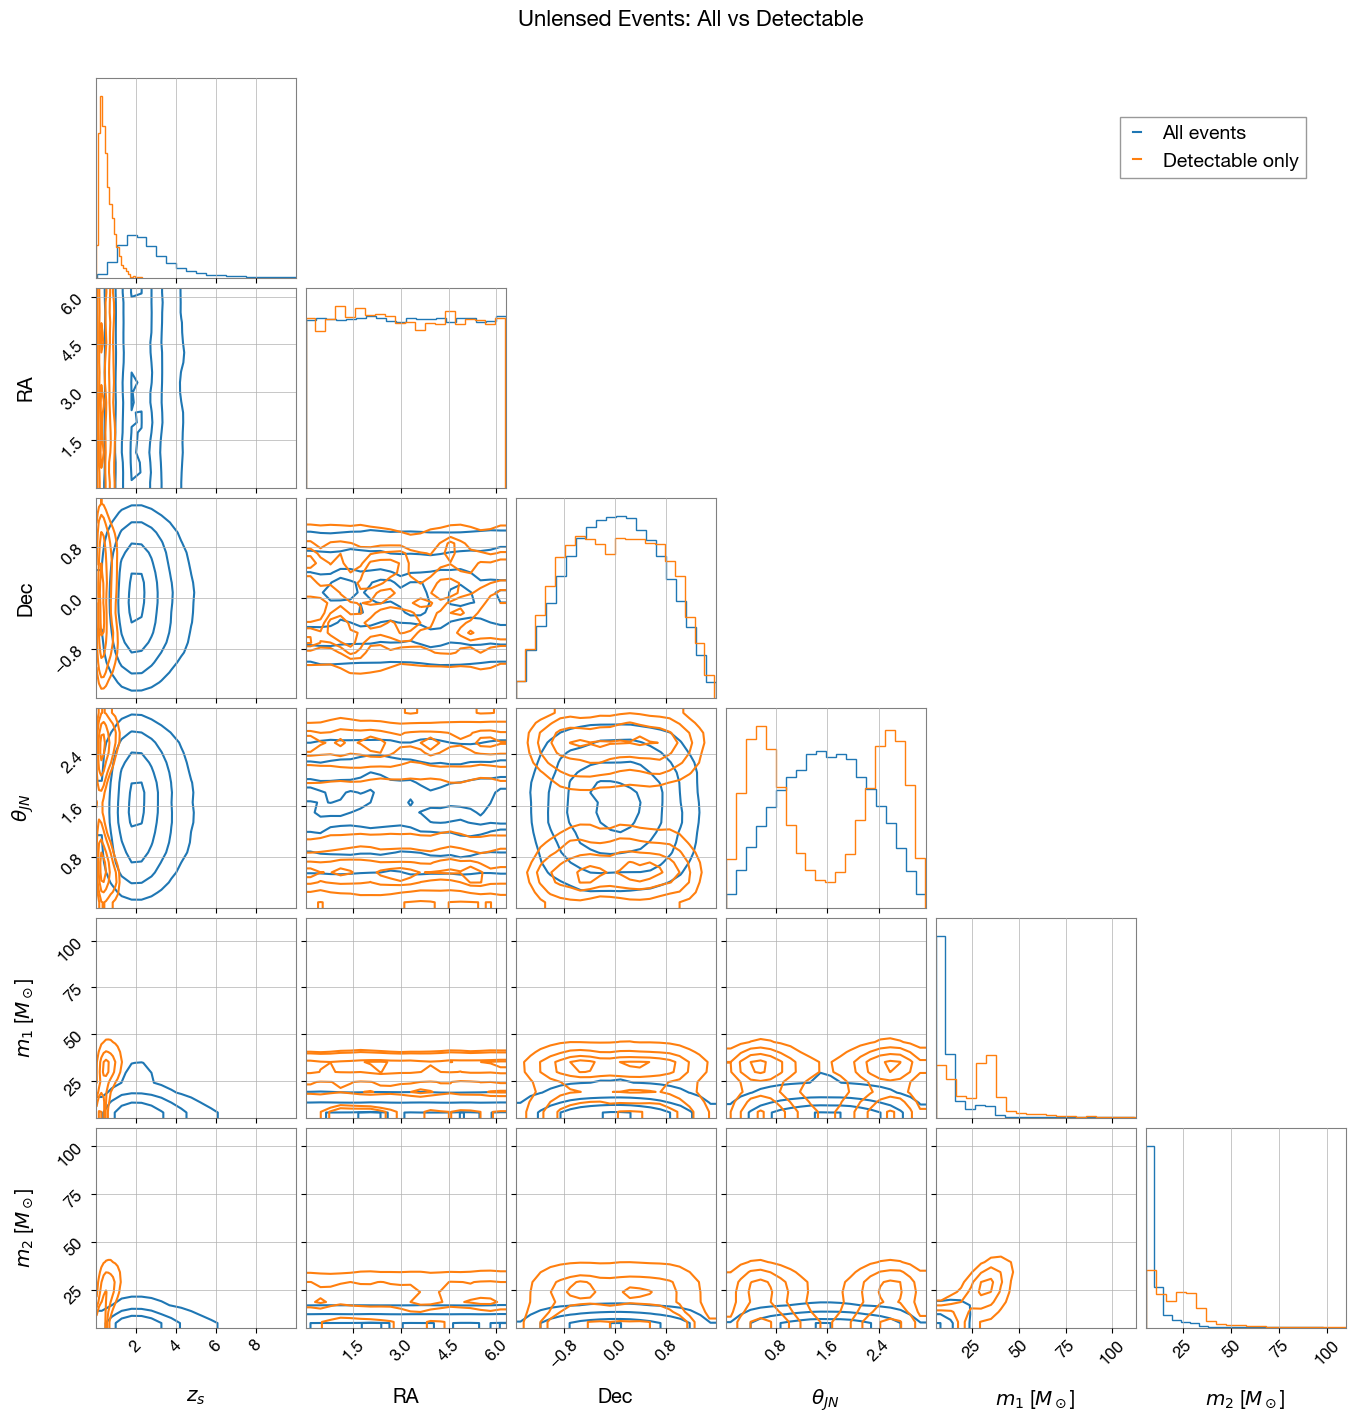

In [12]:
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from ler.utils import get_param_from_json

# Load data
param = get_param_from_json('./ler_data/unlensed_param.json')
param_detectable = get_param_from_json('./ler_data/unlensed_params_n_detectable.json')

# Parameters to compare
param_names = ['zs', 'ra', 'dec', 'theta_jn', 'mass_1_source', 'mass_2_source']
labels = ['$z_s$', 'RA', 'Dec', r'$\theta_{JN}$', '$m_1$ [$M_\odot$]', '$m_2$ [$M_\odot$]']

# Prepare data for corner plot
samples_all = np.stack([param[p] for p in param_names], axis=1)
samples_detectable = np.stack([param_detectable[p] for p in param_names], axis=1)

# Create corner plot for all events
fig = corner.corner(
    samples_all, 
    labels=labels, 
    color='C0', 
    alpha=0.5,
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Overlay detectable events
corner.corner(
    samples_detectable, 
    labels=labels, 
    color='C1', 
    alpha=0.5,
    fig=fig, 
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Add legend
blue_line = mlines.Line2D([], [], color='C0', label='All events')
orange_line = mlines.Line2D([], [], color='C1', label='Detectable only')
fig.legend(handles=[blue_line, orange_line], loc='upper right', 
           bbox_to_anchor=(0.95, 0.95), fontsize=14)
fig.suptitle('Unlensed Events: All vs Detectable', fontsize=16, y=1.02)

plt.show()

### 3.2 Lensed Parameter Distributions

Similarly, compare all lensed events with detectable lensed events.

### 3.2.1 Generate strongly lensed events (detectable and non-detectable)

In [13]:
# Generate a large sample of all lensed events for comparison
lensed_param = ler.lensed_cbc_statistics(size=50000, resume=False)

print(f"Total lensed events sampled: {len(lensed_param['zs'])}")

lensed params will be stored in ./ler_data/lensed_param.json
removing ./ler_data/lensed_param.json if it exists
Batch no. 1
sampling lensed params...
sampling lens parameters with sample_all_routine_epl_shear_sl...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4345.12it/s]


calculating pdet...
lensed parameters already sampled.
saving all lensed parameters in ./ler_data/lensed_param.json 
Total lensed events sampled: 50000


### 3.2.2 Generate intrinsic parameters (without strong lensing selection)

In [14]:
# Generate a large sample of all lensed events for comparison
lensed_param_intrinsic = ler.sample_all_routine_epl_shear_intrinsic(size=50000)

print(f"Total lensed events sampled: {len(lensed_param_intrinsic['zs'])}")

# save to file
from ler.utils import append_json
append_json('lensed_param_intrinsic.json', lensed_param_intrinsic);

Total lensed events sampled: 50000


### 3.2.3 Create a corner plot (lensed events)

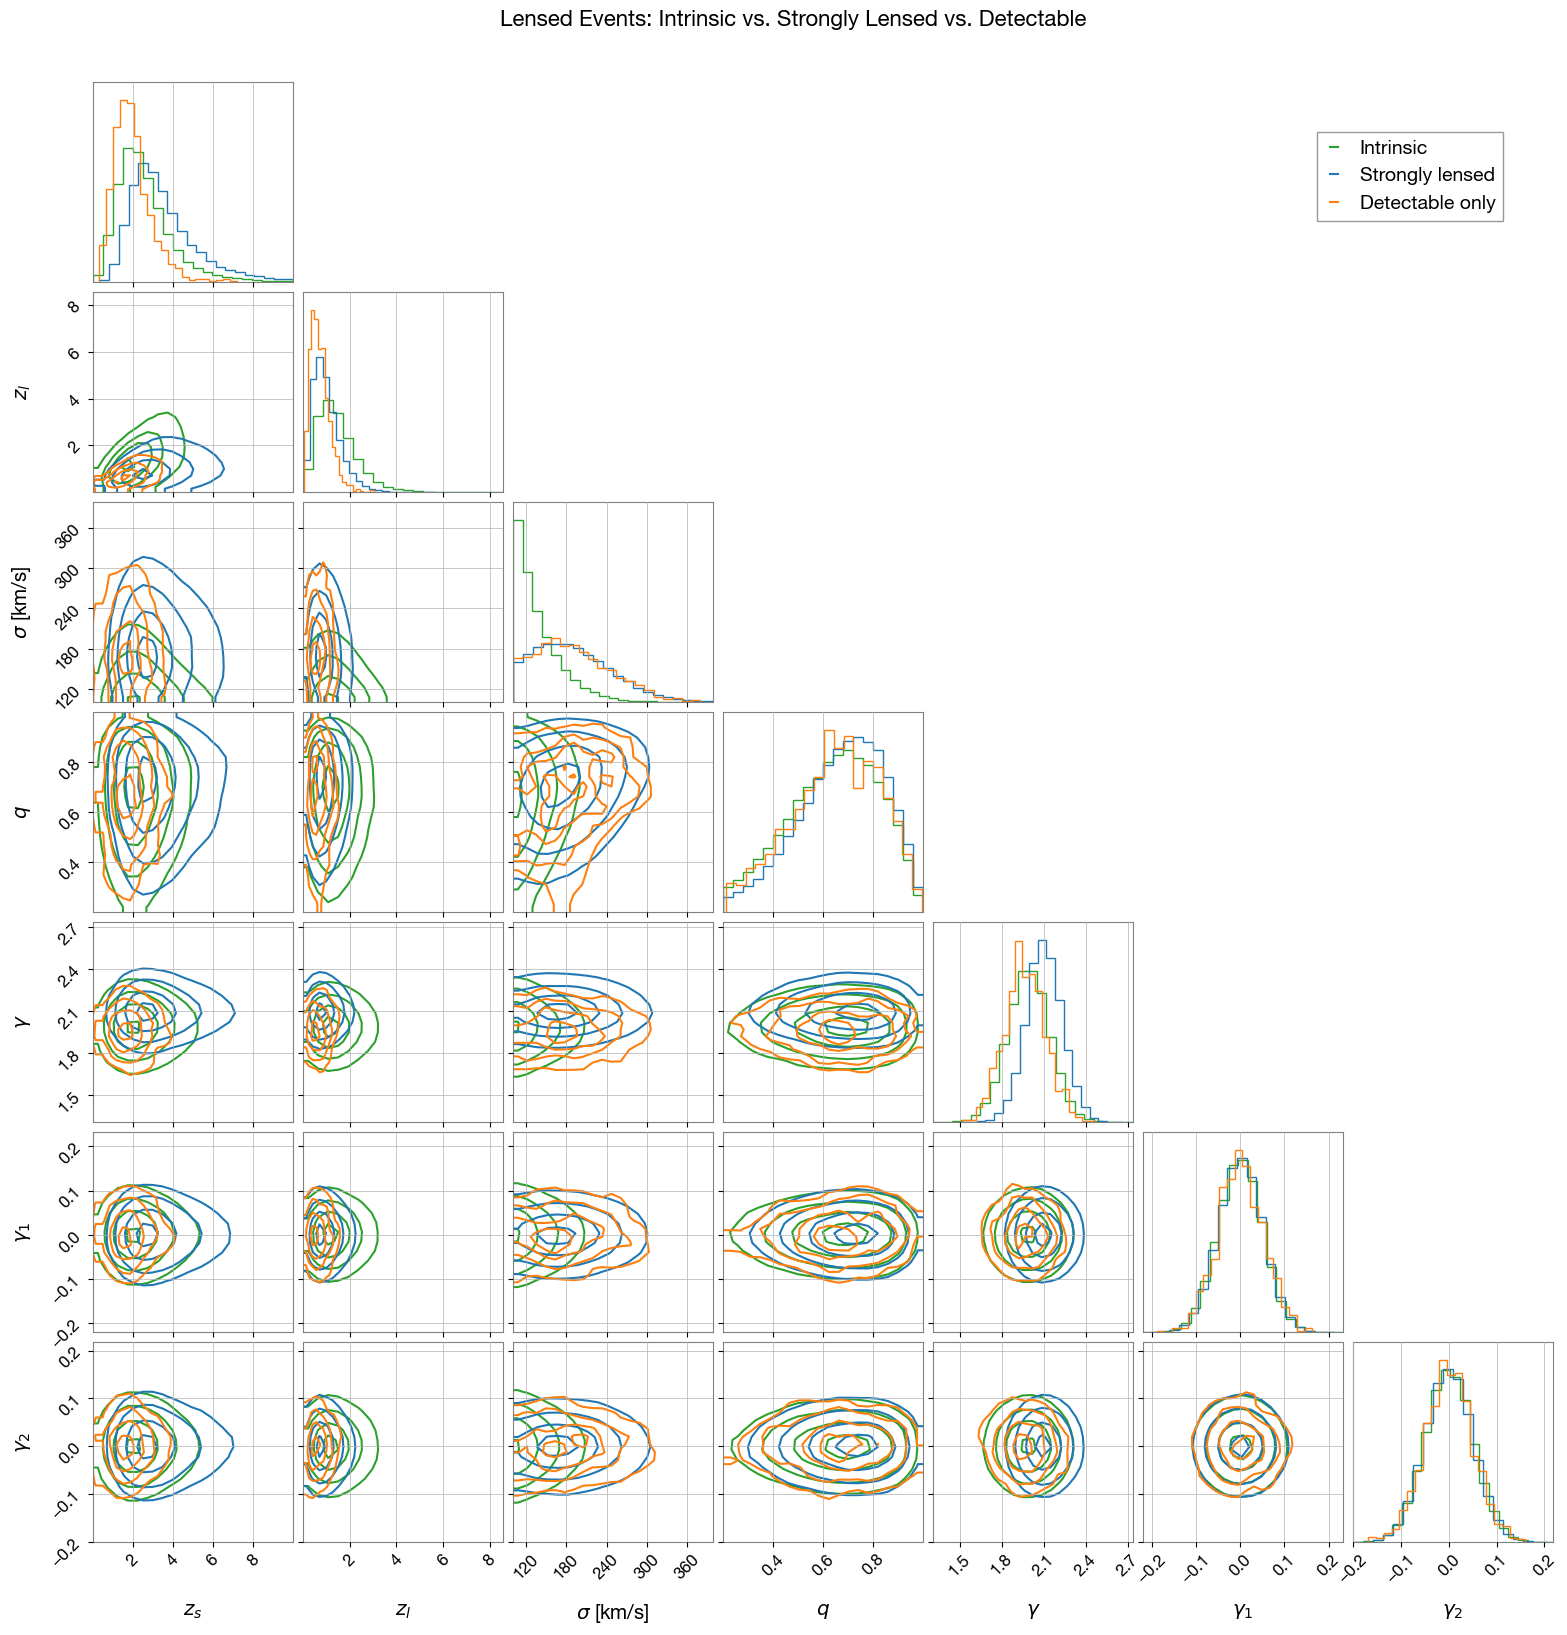

In [15]:
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from ler.utils import get_param_from_json

# Load data
param = get_param_from_json('./ler_data/lensed_param.json')
param_detectable = get_param_from_json('./ler_data/lensed_params_n_detectable.json')
param_intrinsic = get_param_from_json('./ler_data/lensed_param_intrinsic.json')
# lensed_param_intrinsic is already in memory from cell 24

# Lensing-specific parameters to compare
param_names = ['zs', 'zl', 'sigma', 'q', 'gamma', 'gamma1', 'gamma2']
labels = ['$z_s$', '$z_l$', r'$\sigma$ [km/s]', '$q$', r'$\gamma$', r'$\gamma_1$', r'$\gamma_2$']

# Prepare data for corner plot
samples_intrinsic = np.stack([param_intrinsic[p] for p in param_names], axis=1)
samples_all = np.stack([param[p] for p in param_names], axis=1)
samples_detectable = np.stack([param_detectable[p] for p in param_names], axis=1)

# Create corner plot for intrinsic events
fig = corner.corner(
    samples_intrinsic, 
    labels=labels, 
    color='C2', 
    alpha=0.5,
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Overlay strongly lensed events
corner.corner(
    samples_all, 
    labels=labels, 
    color='C0', 
    alpha=0.5,
    fig=fig,
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Overlay detectable events
corner.corner(
    samples_detectable, 
    labels=labels, 
    color='C1', 
    alpha=0.5,
    fig=fig, 
    plot_density=False, 
    plot_datapoints=False, 
    smooth=0.8,
    hist_kwargs={'density': True}
)

# Add legend
green_line = mlines.Line2D([], [], color='C2', label='Intrinsic')
blue_line = mlines.Line2D([], [], color='C0', label='Strongly lensed')
orange_line = mlines.Line2D([], [], color='C1', label='Detectable only')
fig.legend(handles=[green_line, blue_line, orange_line], loc='upper right', 
           bbox_to_anchor=(0.95, 0.95), fontsize=14)
fig.suptitle('Lensed Events: Intrinsic vs. Strongly Lensed vs. Detectable', fontsize=16, y=1.02)

plt.show()

---

## 4. Visualizing Lensed Detectable Event

This section provides visualizations to understand the properties of a chosen detectable lensed event of the population distributions.

### 4.1 Redshift Distribution

Compare the redshift distributions of intrinsic populations with detected populations. Our chosen detectable lensed event is highlighted to see how it compares to the overall population.

Chosen detected lensed event index: 10


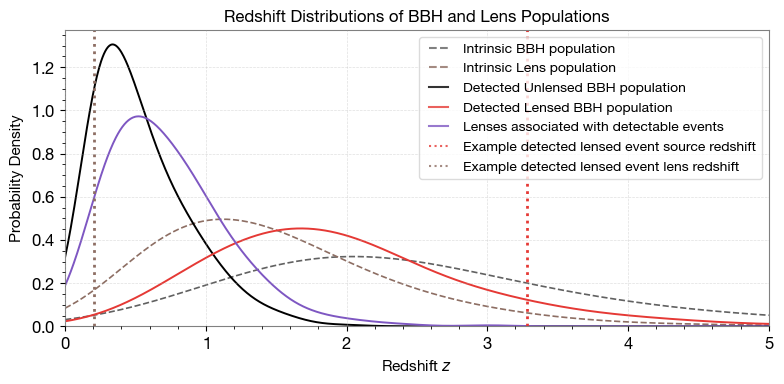

In [2]:
from ler.utils import get_param_from_json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

np.random.seed(100)

# Load data
unlensed_params_det = get_param_from_json('./ler_data/unlensed_params_n_detectable.json')
lensed_params_det = get_param_from_json('./ler_data/lensed_params_n_detectable.json')
unlensed_params = get_param_from_json('./ler_data/unlensed_param.json')
lensed_params = get_param_from_json('./ler_data/lensed_param.json')
lensed_params_intrinsic = get_param_from_json('./ler_data/lensed_param_intrinsic.json')

bbh_pop_intrinsic = unlensed_params['zs']
unlensed_bbh_pop_detected = unlensed_params_det['zs']
lensed_bbh_pop_detected = lensed_params_det['zs']
lens_detected = lensed_params_det['zl']
lens_dist_intrinsic = lensed_params_intrinsic['zl']

# create gaussian kde
from scipy.stats import gaussian_kde
bandwidth = 0.4
kde_bbh_pop_intrinsic = gaussian_kde(bbh_pop_intrinsic, bw_method=bandwidth)
kde_unlensed_bbh_pop_detected = gaussian_kde(unlensed_bbh_pop_detected, bw_method=bandwidth)
kde_lensed_bbh_pop_detected = gaussian_kde(lensed_bbh_pop_detected, bw_method=bandwidth)
kde_lens_dist_intrinsic = gaussian_kde(lens_dist_intrinsic, bw_method=bandwidth)
kde_lens_detected = gaussian_kde(lens_detected, bw_method=bandwidth)

# Choose a random detected lensed event to highlight
pdet = lensed_params_det['pdet_net']
idx_4img = pdet > 0.5
idx_4img = np.sum(idx_4img, axis=1) ==2 # 2 images detected
chosen_idx_list = np.where(idx_4img)[0]
chosen_idx = chosen_idx_list[10]  # pick the 10th one for consistency
print(f"Chosen detected lensed event index: {chosen_idx}")

# ---------- Data ----------
z = np.linspace(0, 5, 1000)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(8, 4))

colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown": "#8D6E63",
    "grey": "#616161",
    "red": "#E53935",
    "blue": "#1E88E5",
}

# intrinsic distributions
ax.plot(z, kde_bbh_pop_intrinsic(z), label='Intrinsic BBH population',
        color=colors["grey"], linestyle='--', linewidth=1.2)
ax.plot(z, kde_lens_dist_intrinsic(z), label='Intrinsic Lens population',
        color=colors["brown"], linestyle='--', linewidth=1.2)

# detected distributions
ax.plot(z, kde_unlensed_bbh_pop_detected(z), label='Detected Unlensed BBH population',
        color=colors["black"], linestyle='-', linewidth=1.4)
ax.plot(z, kde_lensed_bbh_pop_detected(z), label='Detected Lensed BBH population',
        color=colors["red"], linestyle='-', linewidth=1.4)
ax.plot(z, kde_lens_detected(z), label='Lenses associated with detectable events',
        color=colors["violet"], linestyle='-', linewidth=1.4)

# Example detected lensed event redshifts
ax.axvline(lensed_params_det['zs'][chosen_idx],
           color=colors["red"], linestyle=':', linewidth=2,
           label='Example detected lensed event source redshift')
ax.axvline(lensed_params_det['zl'][chosen_idx],
           color=colors["brown"], linestyle=':', linewidth=2,
           label='Example detected lensed event lens redshift')

# ---------- Legend ----------
legend = ax.legend(
    handlelength=2.0,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=True,
    fontsize=10.,
    edgecolor='lightgray'
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1.5)
    handle.set_alpha(0.8)

# ---------- Axes labels, limits, and grid ----------
ax.set_xlabel(r'Redshift $z$', fontsize=11)
ax.set_ylabel(r'Probability Density', fontsize=11)
ax.set_xlim(0, 5)
ax.set_ylim(0, None)

ax.grid(alpha=0.4, linestyle='--', linewidth=0.5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# add title
ax.set_title('Redshift Distributions of BBH and Lens Populations', fontsize=12)

plt.tight_layout()
plt.savefig('lens_paramters_baseline_redshift_distributions.svg',
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### 4.2 Magnification Ratio vs Time Delay 

This plot shows the relationship between relative magnification and time delay for lensed vs unlensed events. Our chosen detectable lensed event is highlighted to see how it compares to the overall population.

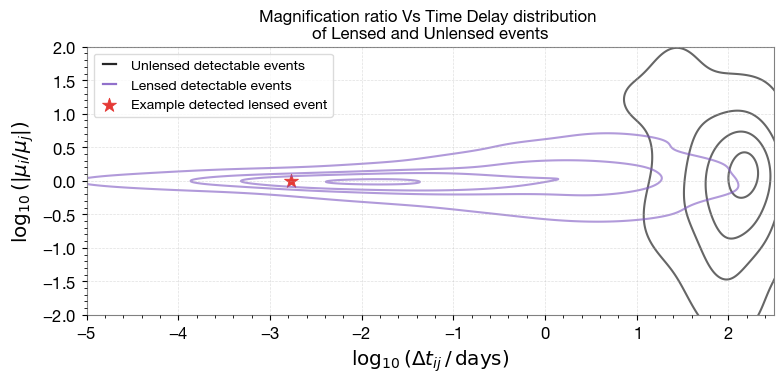

In [3]:
from ler.utils import relative_mu_dt_unlensed, relative_mu_dt_lensed, mu_vs_dt_plot

# for unlensed detectable events
dmu_unlensed, dt_unlensed = relative_mu_dt_unlensed(param=unlensed_params_det)

# for lensed detectable events
lensed_dict = relative_mu_dt_lensed(lensed_param=lensed_params_det)
dt_lensed = np.concatenate((lensed_dict['dt_rel0'], lensed_dict['dt_rel90']))
dmu_lensed = np.concatenate((lensed_dict['mu_rel0'], lensed_dict['mu_rel90']))

# chosen example index for 4 images, find time delays and magnifications
chosen_lens_dt = lensed_params_det['time_delays'][chosen_idx]
chosen_lens_mu = lensed_params_det['magnifications'][chosen_idx]
pdet = lensed_params_det['pdet_net'][chosen_idx]

dt_lensed_chosen = np.log10((chosen_lens_dt[2]-chosen_lens_dt[1])/ (60 * 60 * 24))
dmu_lensed_chosen = np.log10(abs(chosen_lens_mu[2]/chosen_lens_mu[1]))

# ---------------------------------------
# Plot Magnification ratio Vs Time Delay
# ---------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))

colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown": "#8D6E63",
    "grey": "#616161",
    "red": "#E53935",
    "blue": "#1E88E5",
}

# Use your existing helper without modification
mu_vs_dt_plot(dt_unlensed, dmu_unlensed, colors=[colors['black']]*5)
mu_vs_dt_plot(dt_lensed,   dmu_lensed,   colors=[colors['violet']]*5)

# Proxy artists for legend
# Proxy artists for legend
ax.plot([], [], color=colors['black'],  linestyle='-', label='Unlensed detectable events', linewidth=1.5)
ax.plot([], [], color=colors['violet'], linestyle='-', label='Lensed detectable events',   linewidth=1.5)


# Chosen example point
ax.scatter(
    dt_lensed_chosen, dmu_lensed_chosen,
    color=colors['red'], marker='*', s=110, linewidths=0.6,
    label='Example detected lensed event'
)

# ---------- Legend ----------
legend = ax.legend(
    handlelength=1.5,
    loc='upper left',
    bbox_to_anchor=(0, 1),
    frameon=True,
    fontsize=10,
    edgecolor='lightgray'
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1.6)
    handle.set_alpha(0.85)

# add title
ax.set_title('Magnification ratio Vs Time Delay distribution \nof Lensed and Unlensed events', fontsize=12)

# ---------- Axes, ticks, grid ----------
ax.set_xlabel(r'$\log_{10}(\Delta t_{ij} \,/\, \mathrm{days})$')
ax.set_ylabel(r'$\log_{10}(|\mu_i / \mu_j|)$')
ax.set_xlim(-5, 2.5)
ax.set_ylim(-2, 2)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(alpha=0.38, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('mu_vs_dt_science_ieee.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()
# time: 32s

### 4.3 Caustic Plot with Source and Image Positions

Visualize the lens configuration for an example detected lensed event, showing caustics, critical curves, and image positions.

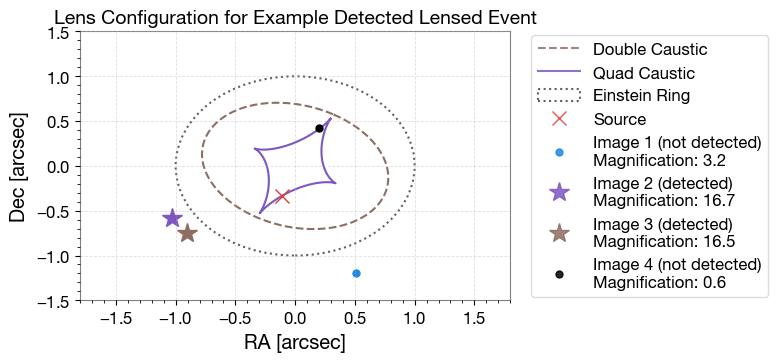

In [4]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
# import phi_q2_ellipticity
from lenstronomy.Util.param_util import phi_q2_ellipticity

# ---------- Custom color palette ----------
colors = {
    "black": "#000000",
    "violet": "#7E57C2",
    "brown":  "#8D6E63",
    "grey":   "#616161",
    "red":    "#E53935",
    "blue":   "#1E88E5",
    "green":  "#43A047",
    "orange": "#FB8C00",
}

# ----- Lens setup -----
lens_model_list = ["EPL", "SHEAR"]
lensModel = LensModel(lens_model_list=lens_model_list)
lens_eq_solver = LensEquationSolver(lensModel)

q   = lensed_params_det['q'][chosen_idx]
phi = lensed_params_det['phi'][chosen_idx]
e1, e2 = phi_q2_ellipticity(phi, q)
kwargs_spep = {
    'theta_E': 1.0,
    'e1': e1,
    'e2': e2,
    'gamma': lensed_params_det['gamma'][chosen_idx],
    'center_x': 0.0,
    'center_y': 0.0,
}
kwargs_shear = {
    'gamma1': lensed_params_det['gamma1'][chosen_idx],
    'gamma2': lensed_params_det['gamma2'][chosen_idx]
}
kwargs_lens = [kwargs_spep, kwargs_shear]

# ----- Solve image configuration -----
theta_E = lensed_params_det['theta_E'][chosen_idx]
# unscaled source position
beta_ra  = lensed_params_det['x_source'][chosen_idx]/theta_E
beta_dec = lensed_params_det['y_source'][chosen_idx]/theta_E
theta_ra, theta_dec = lens_eq_solver.image_position_from_source(
    sourcePos_x=beta_ra, sourcePos_y=beta_dec, kwargs_lens=kwargs_lens,
    solver="analytical", magnification_limit=1.0/100.0, arrival_time_sort=True
)
magnifications = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)
magnifications = np.abs(np.array(magnifications))
# print(f"Magnifications calculated: {magnifications}")

# ----- Figure -----
fig, ax = plt.subplots(figsize=(8, 6))  # wider figure

# Caustics
cp = caustics_epl_shear(kwargs_lens, return_which="double", maginf=-100)
ax.plot(cp[0], cp[1], color=colors['brown'], linewidth=1.5, linestyle='--', label='Double Caustic')
cp = caustics_epl_shear(kwargs_lens, return_which="quad", maginf=-100)
ax.plot(cp[0], cp[1], color=colors['violet'], linewidth=1.5, linestyle='-', label='Quad Caustic')

# Einstein ring
theta_E = 1.0
circle = plt.Circle((0, 0), theta_E, color=colors['grey'], fill=False,
                    linestyle='dotted', linewidth=1.5, label='Einstein Ring')
ax.add_artist(circle)

# Source position
ax.plot(beta_ra, beta_dec, marker='x', ls='None', color=colors['red'], label='Source', markersize=10)

# Image positions
img_colors = [colors['blue'], colors['violet'], colors['brown'], colors['black']]
pdet_image = lensed_params_det['pdet_net'][chosen_idx]
for i in range(len(theta_ra)):
    if pdet_image[i] >= 0.5:
        ax.plot(theta_ra[i], theta_dec[i], marker='*', ls='None',
                color=img_colors[i % len(img_colors)],
                label=f'Image {i+1} (detected)\nMagnification: {magnifications[i]:.1f}', markersize=15)
    else:
        ax.plot(theta_ra[i], theta_dec[i], marker='.', ls='None',
                color=img_colors[i % len(img_colors)],
                label=f'Image {i+1} (not detected)\nMagnification: {magnifications[i]:.1f}', markersize=10)
# Axes & Grid
ax.set_xlabel('RA [arcsec]')
ax.set_ylabel('Dec [arcsec]')
dim_x, dim_y = 1.8, 1.5  # rectangular window
ax.set_xlim(-dim_x, dim_x)
ax.set_ylim(-dim_y, dim_y)

# Relax the aspect ratio → visually rectangular (with adjustable='box' to respect figure size)
ax.set_aspect(6/8, adjustable='box')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(alpha=0.4, linestyle='--', linewidth=0.6)

# Legend on the side
legend = ax.legend(
    handlelength=2.5,
    loc='center left',
    bbox_to_anchor=(1.03, 0.5),
    frameon=True,
    fontsize=12,
    edgecolor='lightgray',
    numpoints=1,  # Show only one marker per legend entry
    scatterpoints=1
)
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
for handle in legend.get_lines():
    handle.set_linewidth(1.5)
    handle.set_alpha(0.85)
# add title
ax.set_title('Lens Configuration for Example Detected Lensed Event', fontsize=14)
plt.tight_layout()
plt.savefig('lens_configuration_rectangular.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

---
## 5. Summary

This notebook demonstrated the advanced sampling capabilities of the **LeR** package for generating detectable gravitational wave events.

### Key Takeaways

1. **N-Event Sampling**: The `selecting_n_unlensed_detectable_events` and `selecting_n_lensed_detectable_events` functions allow collecting a specific number of detectable events with convergence monitoring.

2. **Rate Convergence**: By tracking rates across batches, we can verify when the sampling has reached statistical stability.

3. **Resume Capability**: Sampling can be interrupted and resumed without losing progress.

4. **Selection Effects**: The corner plots reveal how detector sensitivity and strong lensing selection bias the observed populations:
   - **Detector sensitivity effects:**
     - Lower redshift events are preferentially detected
     - Higher mass events have higher detection probability
     - Sky location and orientation effects are visible
   - **Strong lensing selection effects:**
     - Higher magnification events are more likely to be detected
     - Lensed events tend to occur at higher redshifts
     - Lens velocity dispersion influences strong lensing due to increased lensing cross-section
     - Lens galaxy density profile slope affects detectability

5. **Lensing Visualization**: The redshift distributions, magnification-time delay plots, and caustic diagrams provide insight into the properties of detectable lensed events.
